データのimportと関数の定義

In [1]:
# ライブラリのimport
import pandas as pd
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Descriptors, Draw, Recap,rdFingerprintGenerator, rdMolDescriptors
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# smilesからfragmentに分解する関数
def fragment_smiles(smiles):
    # mol file生成
    mol = Chem.MolFromSmiles(smiles)
    # RECAPによる分解
    decomp = Recap.RecapDecompose(mol)
    # smilesを生成してリストに格納
    children = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in list(decomp.children.keys())]
    return children

def fragment_mol(smiles):
    # mol file生成
    mol = Chem.MolFromSmiles(smiles)
    # RECAPによる分解
    decomp = Recap.RecapDecompose(mol)
    # mol filesを生成してリストに格納
    children = [x.mol for x in decomp.children.values()]
    return children

# R分解したフラグメントを抽出してカウントしたdataframeを出力
def count(data):
    df = data
    # childrenカラムのリストをフラットにする
    all_children = [child for sublist in df['children'] for child in sublist]

    # 要素のカウント
    counter = Counter(all_children)

    # カウント結果をデータフレームに変換
    count_df = pd.DataFrame(counter.items(), columns=['Child', 'Count'])

    count_df['MW'] = count_df['Child'].map(lambda x : Descriptors.MolWt(Chem.MolFromSmiles(x)))
    count_df = count_df[count_df['MW']>150]
    return count_df

# count_dfにクラスタリング情報を追加
# https://note.yu9824.com/howto/modern-rdkit-fingerprint/
def clustering(data, split=3):
    count_df = data
    # Smilesを分子オブジェクトに変換
    mols = [Chem.MolFromSmiles(smi) for smi in count_df['Child']]

    # 分子フィンガープrintを生成 (Morganフィンガープrintを使用)
    mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    fps = np.array(mfgen.GetFingerprints(mols, numThreads=1))

    # K-meansクラスタリング (クラスタ数は3とする)
    kmeans = KMeans(n_clusters=split, random_state=0)
    cluster_labels = kmeans.fit_predict(fps)

    # クラスタリング結果をDataFrameに追加
    count_df['clustering'] = cluster_labels
    return count_df

# count_dfのtop20のフラグメントを描画
def cluster_img(data, num=20):
    top = data.sort_values(by='Count', ascending=False).head(num)
    topmol = [Chem.MolFromSmiles(smiles) for smiles in list(top['Child'])]
    return Draw.MolsToGridImage(
        topmol, molsPerRow=4, legends=[str(x) for x in top['clustering']], subImgSize=(300,200))

def count_img(data, num=20):
    top = data.sort_values(by='Count', ascending=False).head(num)
    topmol = [Chem.MolFromSmiles(smiles) for smiles in list(top['Child'])]
    return Draw.MolsToGridImage(
        topmol, molsPerRow=4, legends=[str(x) for x in top['Count']], subImgSize=(300,200))

# load df
df = pd.read_csv('./protac.csv', low_memory=False)

# 命名されたPROTACにfiltering
# df = df[df['Name'].notna()].drop_duplicates(subset=['Name'])


In [81]:
df

,Compound ID,Uniprot,Target,E3 ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,XLogP3,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key
0,1,Q9NPI1,BRD7,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N
1,1,Q9H8M2,BRD9,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,3.03,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N
2,2,Q9NPI1,BRD7,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,2.74,74,7,17,3,25,208.38,C54H72N8O11S,InChI=1S/C54H72N8O11S/c1-36-49(74-35-57-36)38-...,NGWWVKZONFCNQP-SHPBXJAASA-N
3,2,Q9H8M2,BRD9,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,2.74,74,7,17,3,25,208.38,C54H72N8O11S,InChI=1S/C54H72N8O11S/c1-36-49(74-35-57-36)38-...,NGWWVKZONFCNQP-SHPBXJAASA-N
4,3,Q9H8M2,BRD9,CRBN,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,0.70,61,7,15,3,18,202.97,C43H50N8O10,InChI=1S/C43H50N8O10/c1-48-24-31(28-9-10-44-23...,RMBNUDOJPQLHMV-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9375,6107,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCNC(=O)CC...,NaN,NaN,NaN,...,4.17,62,6,14,5,17,212.60,C44H56N10O7S,InChI=1S/C44H56N10O7S/c1-28-7-6-8-31(21-28)25-...,PQSNYQRLQZKOHU-PIRXKMKRSA-N
9376,6108,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCNC(=O)CC...,NaN,NaN,NaN,...,4.53,63,6,14,5,18,212.60,C45H58N10O7S,InChI=1S/C45H58N10O7S/c1-29-8-6-9-32(22-29)26-...,JSVJNUZMVMEXDV-SFJLORJHSA-N
9377,6109,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCC3=CC=C(...,NaN,NaN,NaN,...,6.80,67,7,14,5,17,212.60,C49H58N10O7S,InChI=1S/C49H58N10O7S/c1-31-7-6-8-35(23-31)28-...,MBNBFRCFIJBTNO-TXSHVJCESA-N
9378,6110,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCC3=CC=C(...,NaN,NaN,NaN,...,6.35,69,7,14,5,19,212.60,C51H62N10O7S,InChI=1S/C51H62N10O7S/c1-33-8-6-9-37(26-33)30-...,ZUUHYVUYFOXYJE-YJZDUONUSA-N


R分解して保存

In [40]:
# 100行ずつに分割して処理を行い、df2に連結
df2 = pd.DataFrame()

for i in range(0, len(df), 100):
    df_chunk = df.iloc[i:i+100].copy()  # 100行ずつのチャンクを作成
    df_chunk['children'] = df_chunk['Smiles'].map(lambda x: fragment_smiles(x))
    df2 = pd.concat([df2, df_chunk], ignore_index=True)  # df2に連結
    print(len(df2))

df2.to_csv('./protac_decomp.csv', index=False)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9380


保存したデータの読み込み

In [3]:
# 保存したcsvを読み込む
import ast
# カスタム関数を定義して、文字列をリストに変換
def str_to_list(s):
    return ast.literal_eval(s)

df2 = pd.read_csv('./protac_decomp.csv', low_memory=False, converters={'children': str_to_list})
# df2['children'].iloc[0]
df2

,Compound ID,Uniprot,Target,E3 ligase,PDB,Name,Smiles,DC50 (nM),Dmax (%),Assay (DC50/Dmax),...,Heavy Atom Count,Ring Count,Hydrogen Bond Acceptor Count,Hydrogen Bond Donor Count,Rotatable Bond Count,Topological Polar Surface Area,Molecular Formula,InChI,InChI Key,children
0,1,Q9NPI1,BRD7,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,[*N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1ccc(-...
1,1,Q9H8M2,BRD9,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,68,7,15,3,19,189.92,C50H64N8O9S,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,RPMQBLMPGMFXLD-PDUNVWSESA-N,[*N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1ccc(-...
2,2,Q9NPI1,BRD7,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,74,7,17,3,25,208.38,C54H72N8O11S,InChI=1S/C54H72N8O11S/c1-36-49(74-35-57-36)38-...,NGWWVKZONFCNQP-SHPBXJAASA-N,[*N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1ccc(-...
3,2,Q9H8M2,BRD9,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,74,7,17,3,25,208.38,C54H72N8O11S,InChI=1S/C54H72N8O11S/c1-36-49(74-35-57-36)38-...,NGWWVKZONFCNQP-SHPBXJAASA-N,[*N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1ccc(-...
4,3,Q9H8M2,BRD9,CRBN,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,NaN,NaN,NaN,...,61,7,15,3,18,202.97,C43H50N8O10,InChI=1S/C43H50N8O10/c1-48-24-31(28-9-10-44-23...,RMBNUDOJPQLHMV-UHFFFAOYSA-N,"[*NCCNc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O, *C(..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9375,6107,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCNC(=O)CC...,NaN,NaN,NaN,...,62,6,14,5,17,212.60,C44H56N10O7S,InChI=1S/C44H56N10O7S/c1-28-7-6-8-31(21-28)25-...,PQSNYQRLQZKOHU-PIRXKMKRSA-N,"[*NCCOc1nc(N/N=C/c2cccc(C)c2)cc(N2CCOCC2)n1, *..."
9376,6108,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCNC(=O)CC...,NaN,NaN,NaN,...,63,6,14,5,18,212.60,C45H58N10O7S,InChI=1S/C45H58N10O7S/c1-29-8-6-9-32(22-29)26-...,JSVJNUZMVMEXDV-SFJLORJHSA-N,"[*NCCOc1nc(N/N=C/c2cccc(C)c2)cc(N2CCOCC2)n1, *..."
9377,6109,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCC3=CC=C(...,NaN,NaN,NaN,...,67,7,14,5,17,212.60,C49H58N10O7S,InChI=1S/C49H58N10O7S/c1-31-7-6-8-35(23-31)28-...,MBNBFRCFIJBTNO-TXSHVJCESA-N,[*Nc1ccc(CCOc2nc(N/N=C/c3cccc(C)c3)cc(N3CCOCC3...
9378,6110,Q9Y2I7,PIKfyve,VHL,NaN,NaN,CC1=CC=CC(/C=N/NC2=CC(N3CCOCC3)=NC(OCCC3=CC=C(...,NaN,NaN,NaN,...,69,7,14,5,19,212.60,C51H62N10O7S,InChI=1S/C51H62N10O7S/c1-33-8-6-9-37(26-33)30-...,ZUUHYVUYFOXYJE-YJZDUONUSA-N,[*Nc1ccc(CCOc2nc(N/N=C/c3cccc(C)c3)cc(N3CCOCC3...


R分解したフラグメントを描画して確認

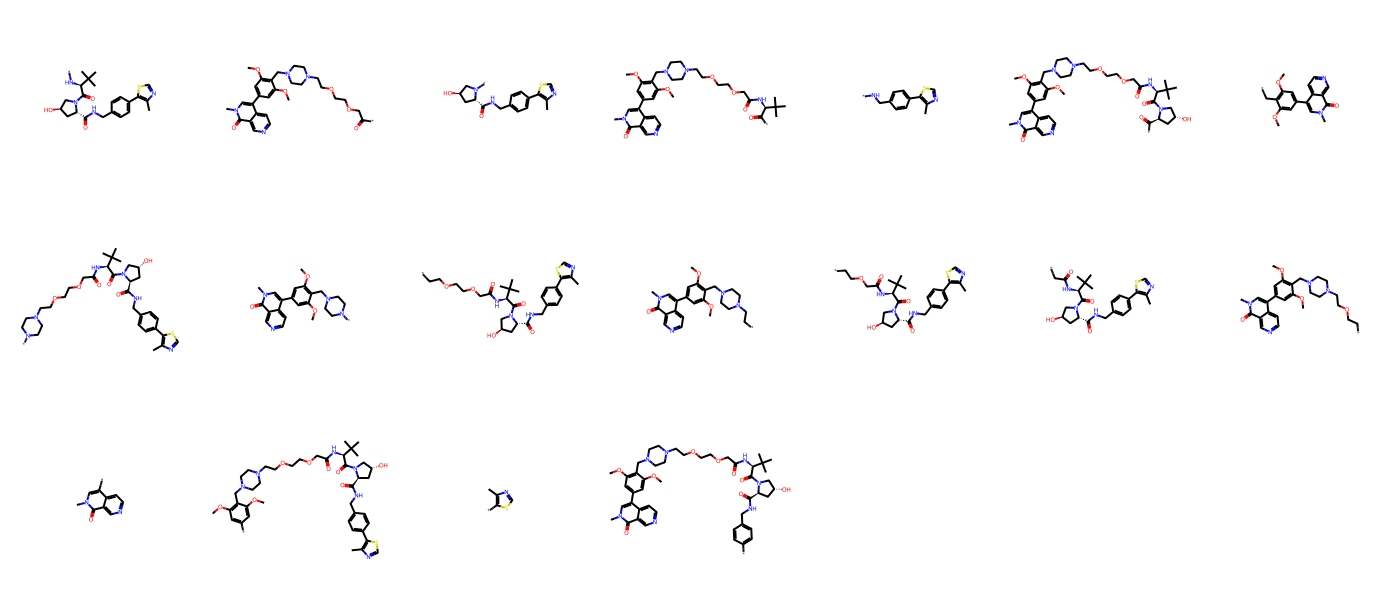

In [4]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in df2['children'].iloc[0]],
    molsPerRow=7
)

E3を確認

In [5]:
df2['E3 ligase'].unique()

array(['VHL', 'CRBN', 'DCAF15', 'MDM2', 'cIAP1', 'XIAP', 'DCAF16', 'AhR',
       'IAP', 'RNF4', 'RNF114', 'DCAF11', 'FEM1B', 'FBXO22', 'BRD4',
       'Keap1', 'KLHL20', 'DCAF1', 'KEAP1', 'UBR box', 'KLHDC2'],
      dtype=object)

In [12]:
df2.drop_duplicates(subset='Smiles')['E3 ligase'].value_counts()

E3 ligase
CRBN       3860
VHL        1914
cIAP1        94
MDM2         57
IAP          48
XIAP         39
DCAF16       32
KEAP1        12
KLHL20        9
Keap1         8
DCAF1         7
FEM1B         7
BRD4          5
RNF114        4
AhR           4
DCAF11        3
KLHDC2        3
FBXO22        2
DCAF15        2
UBR box       2
RNF4          1
Name: count, dtype: int64

E3をCRBNに指定してトップランクのフラグメントを描画

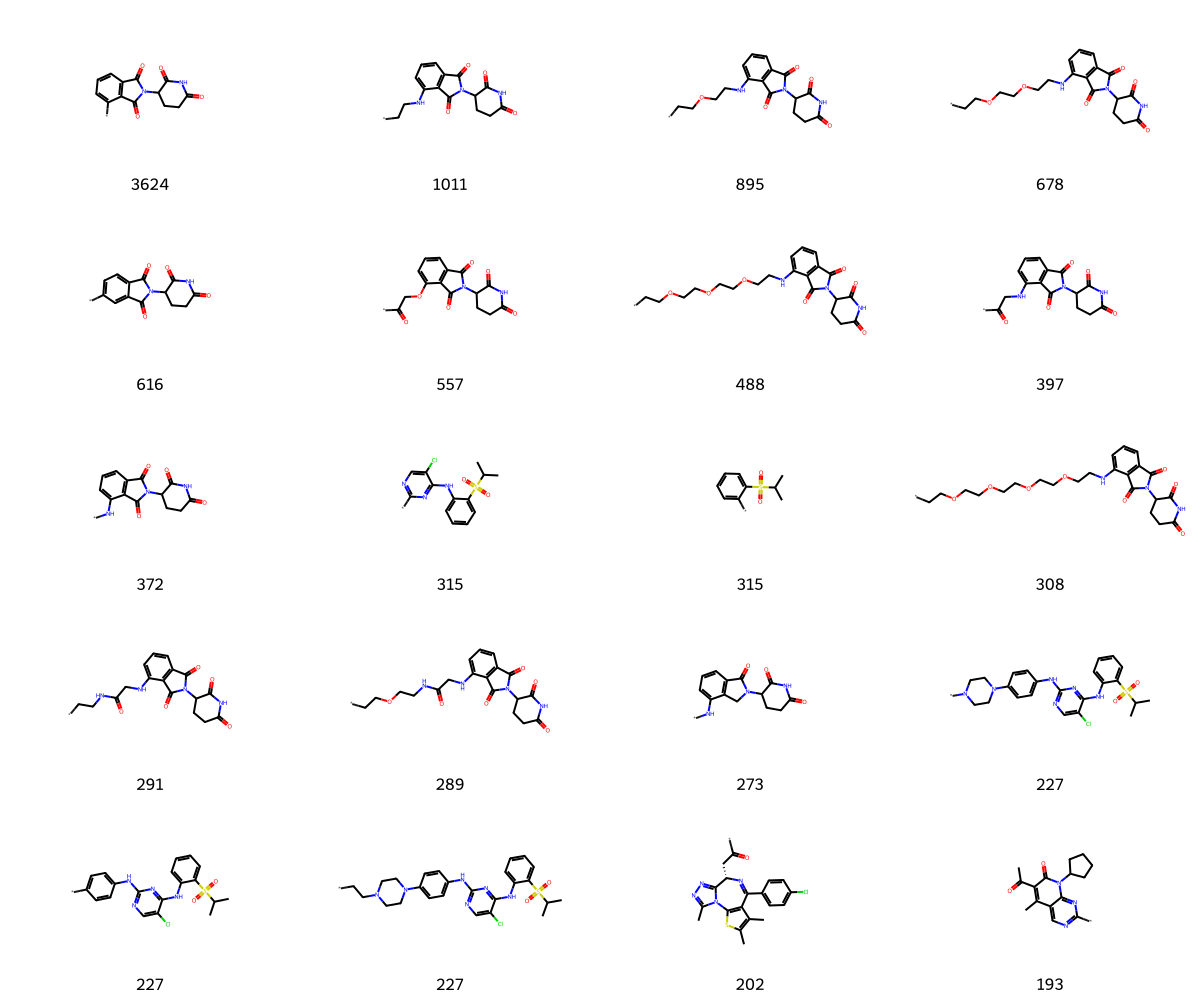

In [13]:
# E3ligaseを指定
df_crbn = df2[df2['E3 ligase']=='CRBN']
count_df = count(df_crbn)
count_img(count_df)

標的のランキング

<Axes: ylabel='Target'>

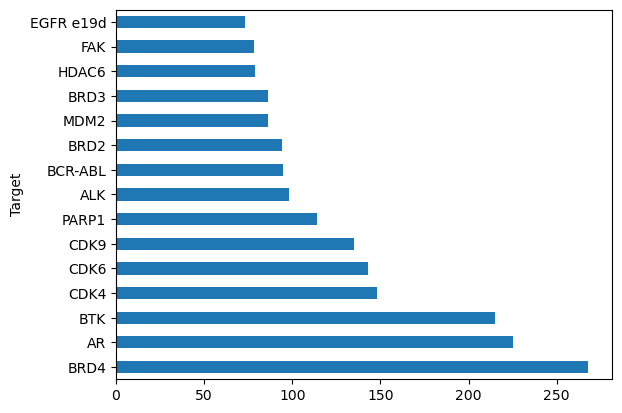

In [73]:
value_counts = df_crbn['Target'].value_counts()
value_counts.head(15).plot(kind='barh')

BRD4にfilteringしてE3のランキングを表示

CRBNのデータをクラスタリング

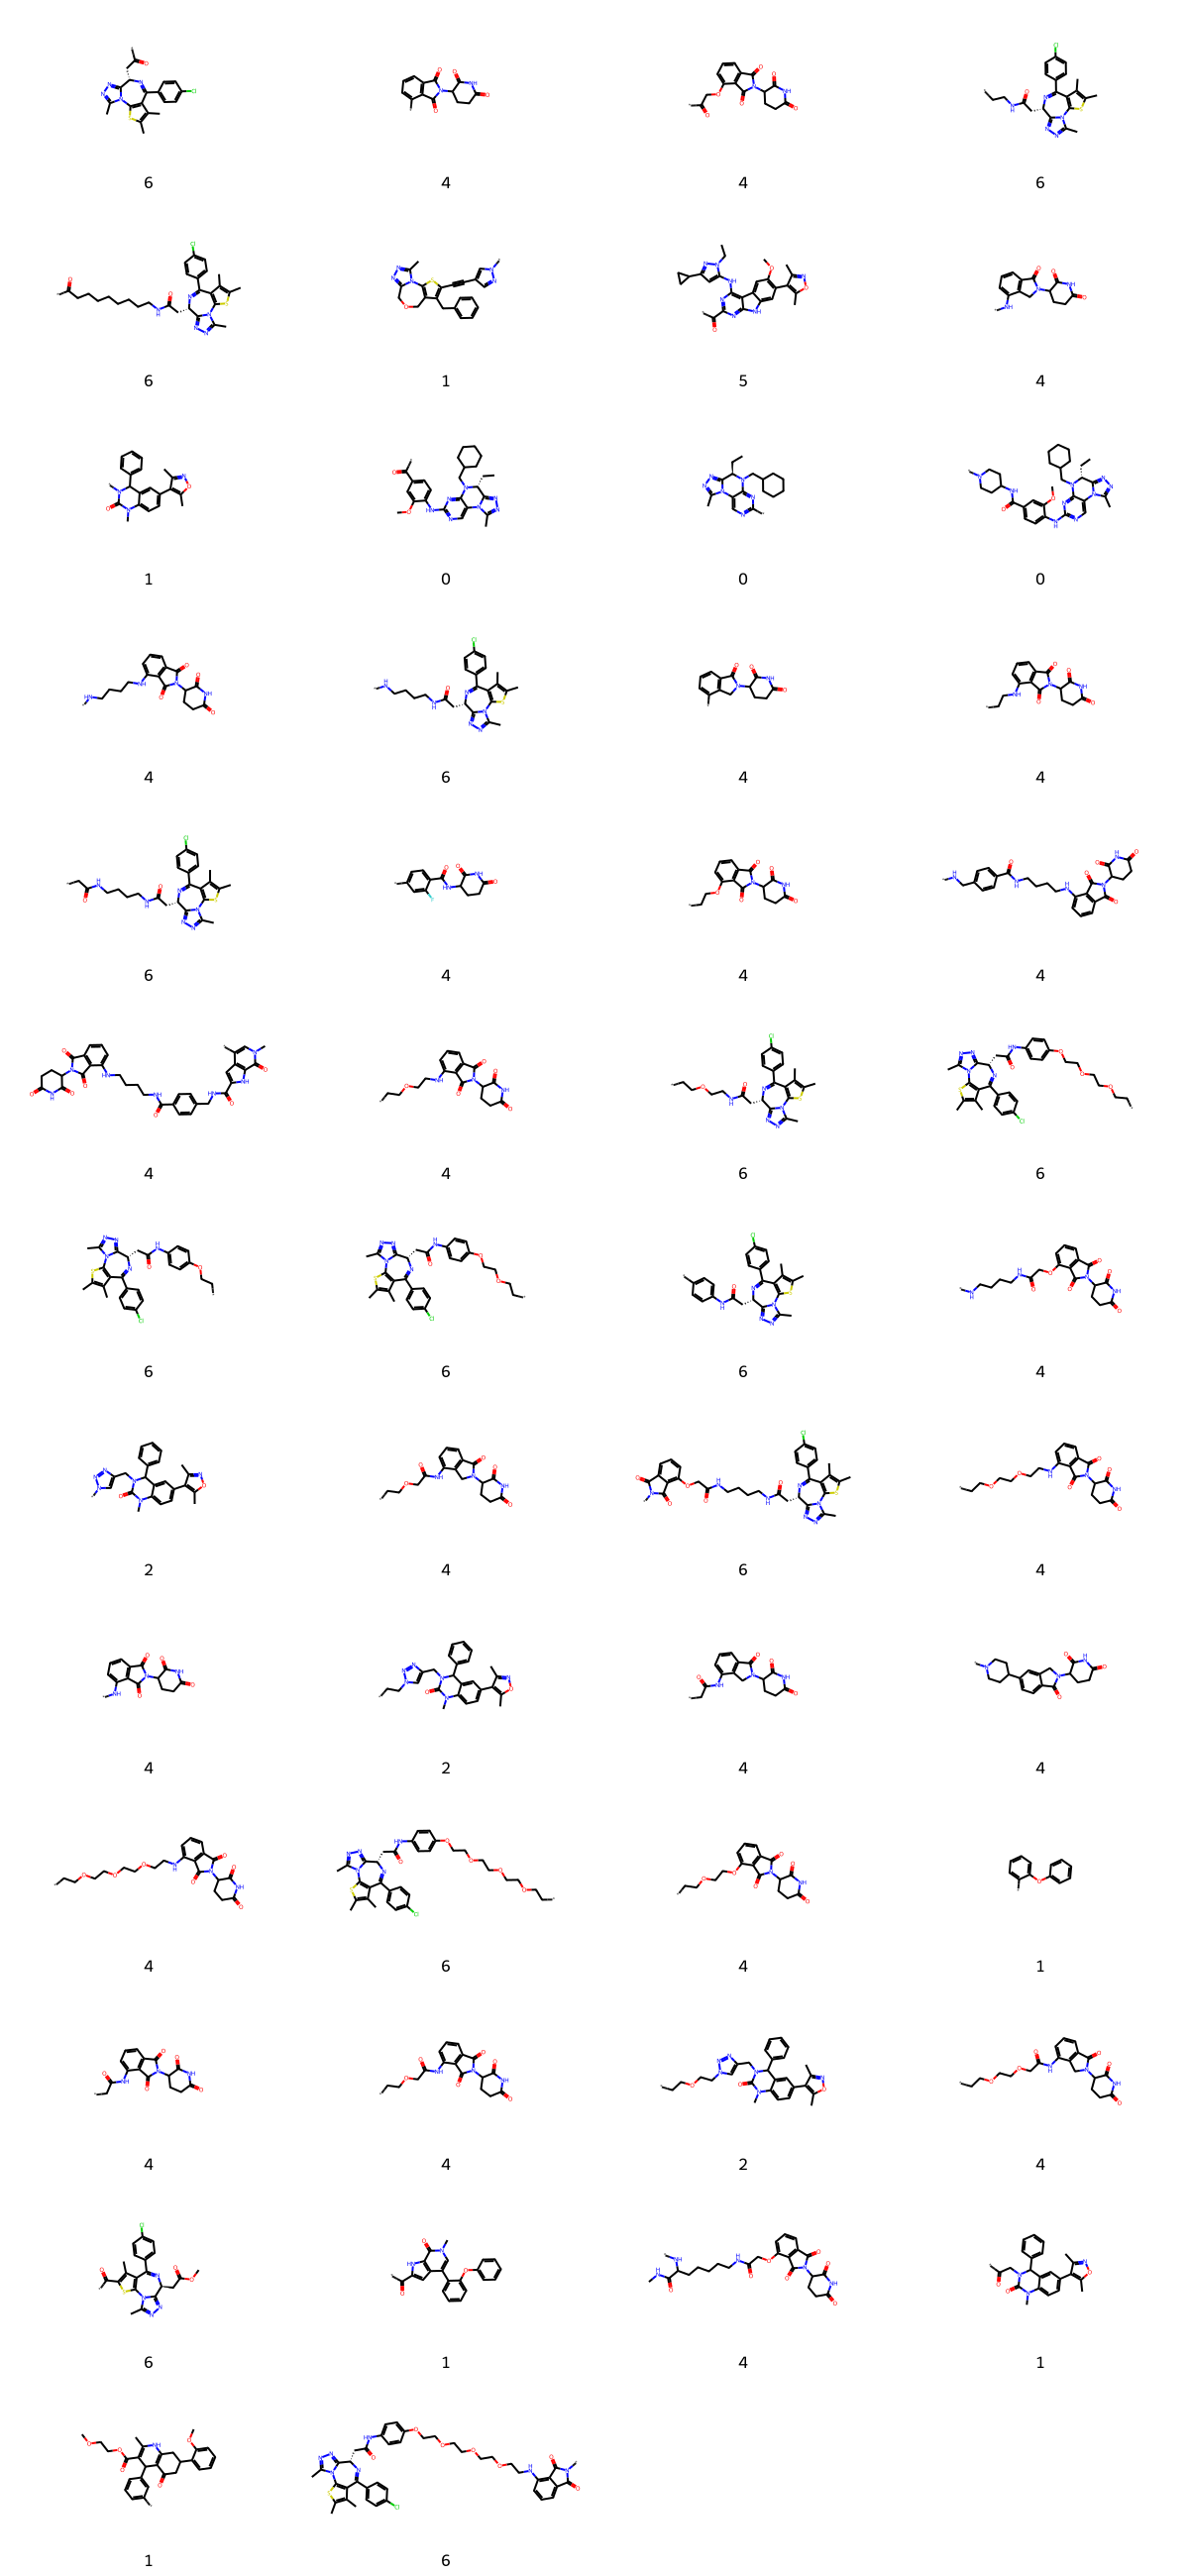

In [77]:
df_brd4 = df_crbn[df_crbn['Target']=='BRD4']
count_df = clustering(count(df_brd4), 7)
cluster_img(count_df, 50)
# 4がCRBNリガンドっぽい

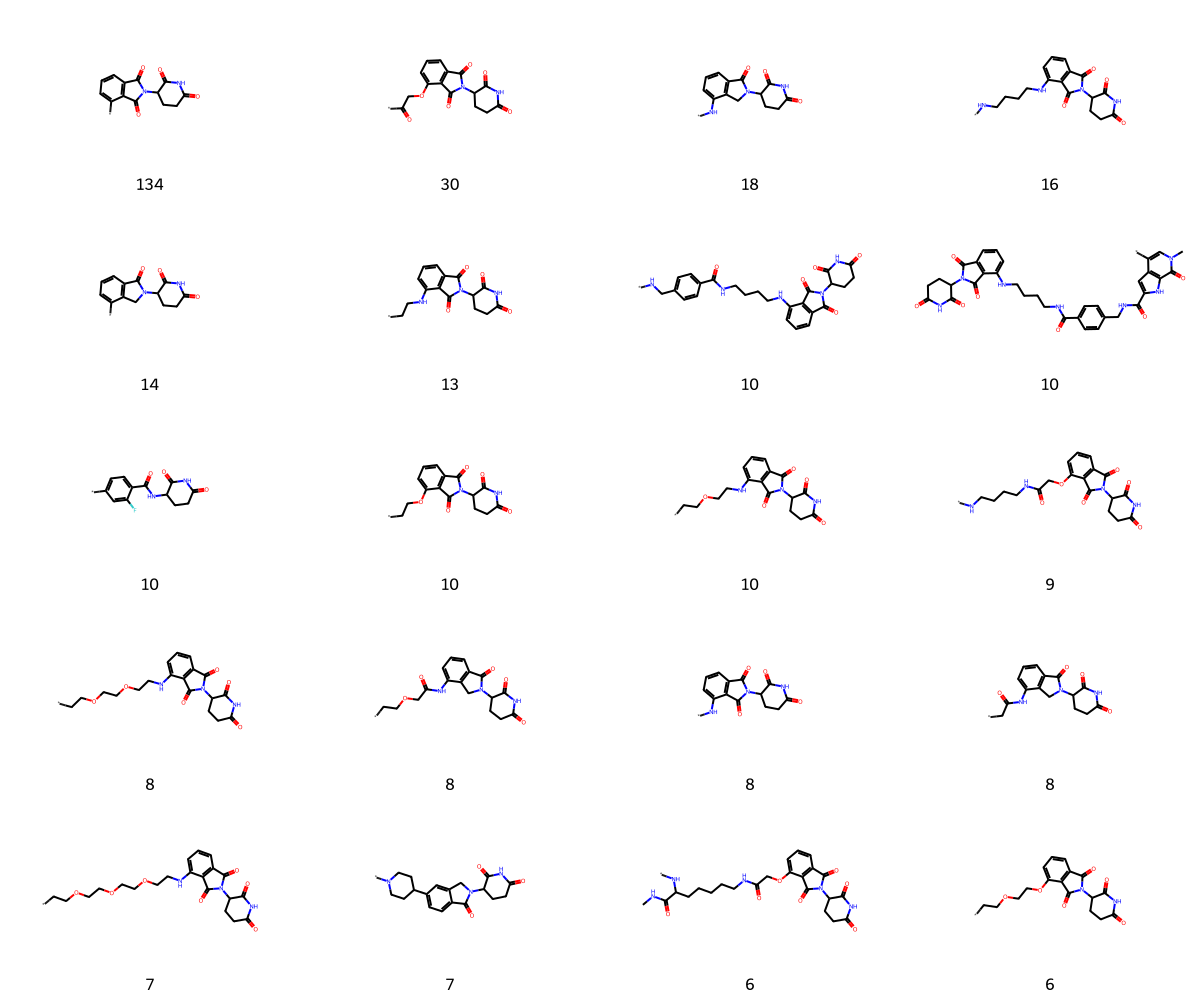

In [76]:
count_df_crbn = count_df[count_df['clustering']==4].sort_values(by='Count', ascending=False)
count_img(count_df_crbn)

全標的でのCRBNリガンドを確認

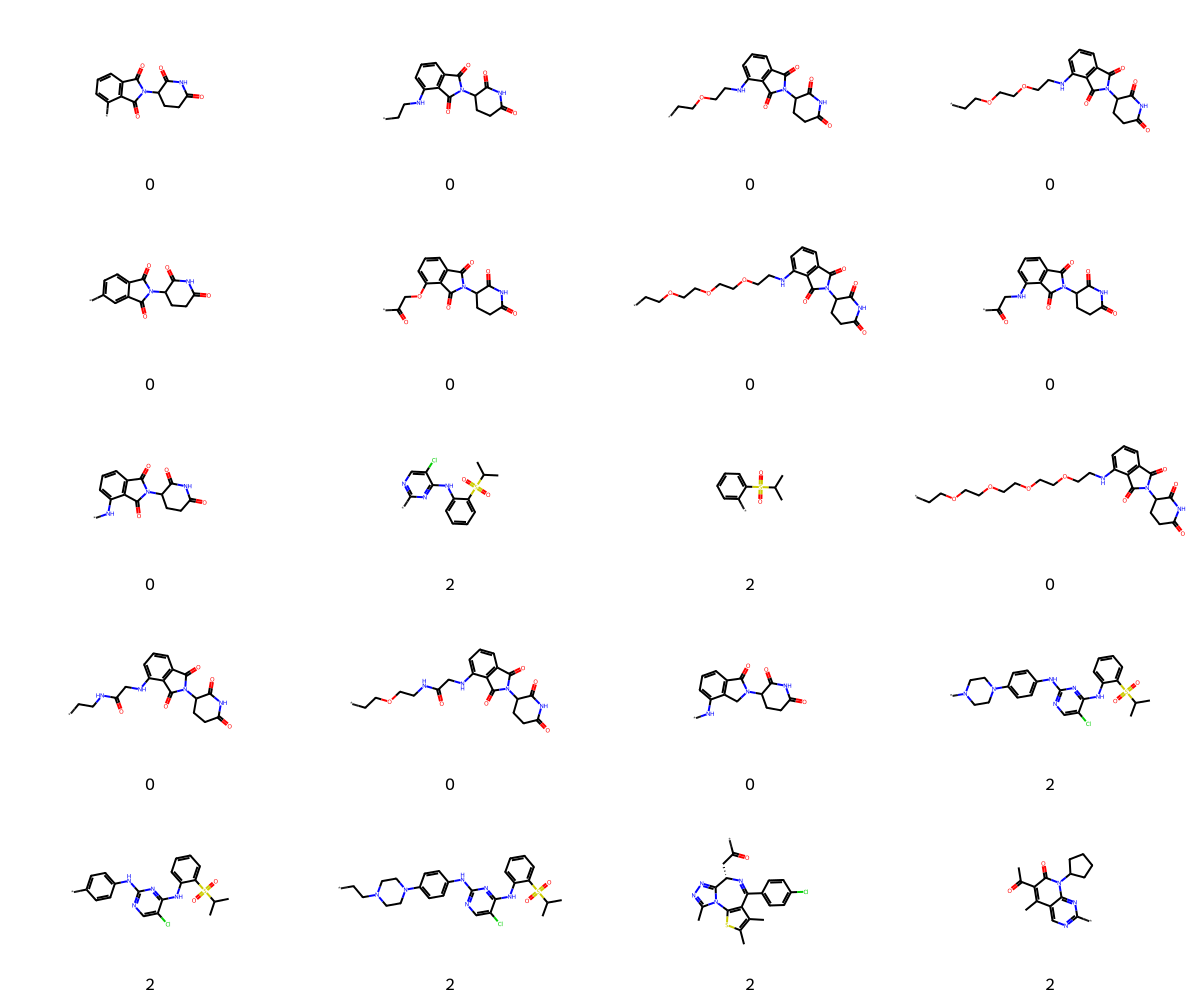

In [79]:
# E3ligaseを指定
df_crbn = df2[df2['E3 ligase']=='CRBN']
count_df = count(df_crbn)
clustering(count_df)
cluster_img(count_df)
# cluster 0がCRBNリガンドっぽい

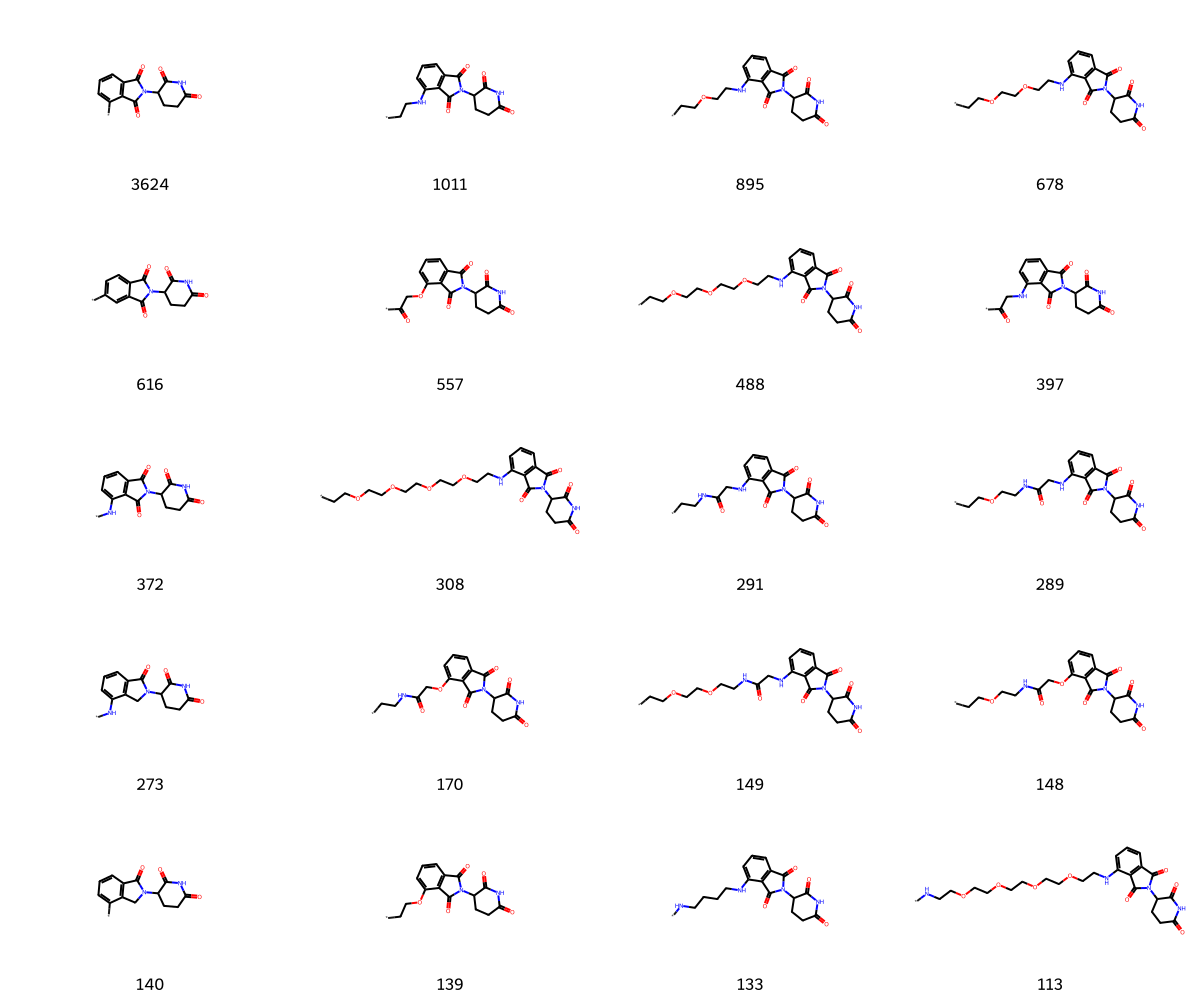

In [80]:
count_df = count_df[count_df['clustering']==0].sort_values(by='Count', ascending=False)
count_img(count_df)
